In [1]:
import sys
sys.path.append("..")
import numpy as np
from simulator import AnalogCore
from simulator import CrossSimParameters
from applications.mvm_params import set_params
import scipy.linalg
import matplotlib.pyplot as plt
from PIL import Image
np.random.seed(198)

# ADC Quantization Illustrations

This section demonstrates how the ADC quantization affects the output of an analog computation in an Analog Matrix Processor (AMP). A 128-point Discrete Fourier Transform (DFT) matrix `W` is created; a rectangular pulse `x` is defined, which serves as a simple, discrete signal; the variable `y_np` represents the output of the matrix-vector multiplication (MVM) using NumPy's high precision calculations. It serves as a baseline for comparison; three different AMP configurations are created with 16-bit precision for weights and inputs but varying ADC bit levels `(4, 6, and 8 bits)`; the AMP cores (`xbar_4b`, `xbar_6b`, `xbar_8b`) perform the analog MVM with the DFT matrix and the rectangular pulse input, resulting in `y_xbar_4b`, `y_xbar_6b`, and `y_xbar_8b` outputs.

The intuition this setup provides is related to the resolution of the ADC and its impact on the accuracy of the analog computation output. Since the DFT operation amplifies the effects of quantization (due to the presence of high-frequency components in the rectangular pulse), any loss of precision due to lower ADC resolution will be visible in the frequency domain representation.

In [10]:
# DFT matrix
N_ft1 = 128
W = np.real(scipy.linalg.dft(N_ft1))

# Create a rectangular pulse input
x = np.zeros(N_ft1)
x[122:133] = 1
y_np = W @ x

# Set parameters for the three different levels of quantization
params_4b = set_params(
    weight_bits = 16, weight_percentile = 100,
    input_bits = 16, input_range = (-1, 1),
    adc_bits = 4, adc_range = (-12,12))

params_6b = set_params(
    weight_bits = 16, weight_percentile = 100,
    input_bits = 16, input_range = (-1, 1),
    adc_bits = 6, adc_range = (-12,12))

params_8b = set_params(
    weight_bits = 16, weight_percentile = 100,
    input_bits = 16, input_range = (-1, 1),
    adc_bits = 8, adc_range = (-12,12))

# Create AnalogCores and program matrix
xbar_4b = AnalogCore(W, params=params_4b)
xbar_6b = AnalogCore(W, params=params_6b)
xbar_8b = AnalogCore(W, params=params_8b)

# Compute the analog MVM
y_xbar_4b = xbar_4b @ x
y_xbar_6b = xbar_6b @ x
y_xbar_8b = xbar_8b @ x

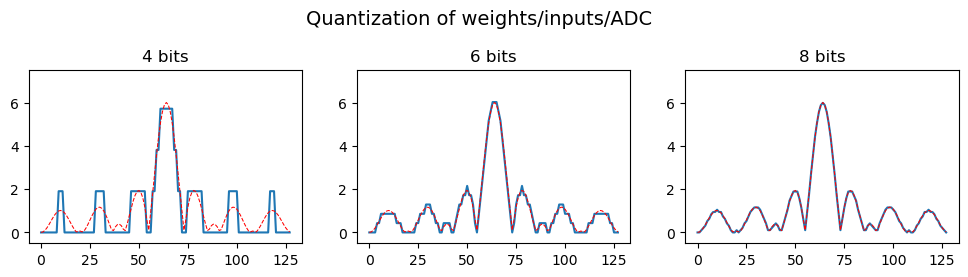

In [11]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,2.25))
plt.subplots_adjust(hspace=0.3)
ax1.plot(np.fft.fftshift(np.abs(y_xbar_4b)))
ax2.plot(np.fft.fftshift(np.abs(y_xbar_6b)))
ax3.plot(np.fft.fftshift(np.abs(y_xbar_8b)))
for ax in (ax1,ax2,ax3):
    ax.plot(np.fft.fftshift(np.abs(y_np)),'--r',linewidth=0.75)
    ax.set_ylim([-0.5,7.5])
fig.suptitle("Quantization of weights/inputs/ADC",fontsize=14,y=1.15)
ax1.set_title("4 bits")
ax2.set_title("6 bits")
ax3.set_title("8 bits")
plt.show()

By comparing the plots for 4, 6, and 8-bit ADC quantization levels, you should see:

4-bit ADC: The lowest resolution, which will likely show the greatest deviation from the theoretical output, possibly with noticeable quantization noise or distortion.
6-bit ADC: An intermediate resolution, with less deviation and noise compared to 4-bit, but still with some inaccuracies.
8-bit ADC: The highest resolution of the three, which should be closer to the theoretical output, with less quantization noise and higher fidelity.

# Negative value representation



## Balanced Positive and Negative
In the balanced scheme, positive and negative weights of the matrix are mapped to two separate physical entities—core_pos and core_neg. This could mean that one set of devices within the crossbar array represents the positive values, while another set represents the negative values.

The balanced scheme should ideally allow for a symmetric and linear representation of both positive and negative values, which can be crucial for maintaining the accuracy of computations that involve both types of values.

The patterns indicate that the positive and negative values are represented separately but in a complementary manner, which allows for the full range of DFT output to be represented by combining the contributions from both positive set and negative set.


## Offset Mapping

In the offset scheme, all weights (positive and negative) are mapped onto a single core (core.matrix), likely using an offset to handle negative values. This means that the conductance values are adjusted so that a certain baseline conductance represents zero, with values above and below this baseline representing positive and negative weights, respectively.

This method simplifies the hardware design by not requiring separate physical cores for positive and negative values, but it may introduce asymmetries or non-linearities in how values are represented, potentially impacting the accuracy of the computations.


In [18]:
# Define 64-point DFT matrix
N = 64
W_rdft = np.real(scipy.linalg.dft(N))

# Balanced core params
params_balanced = set_params(weight_bits = 16, 
                             wtmodel="BALANCED", 
                             Rmin = 1e3, 
                             Rmax = 1e6)

# Offset core params
params_offset = set_params(weight_bits = 16,
                           wtmodel="OFFSET",
                           Rmin = 1e3,
                           Rmax = 1e6)

# Create cores and program matrix
xbar_balanced = AnalogCore(W_rdft, params = params_balanced)
xbar_offset = AnalogCore(W_rdft, params = params_offset)

This is a visual representation of the 64-point Discrete Fourier Transform (DFT) matrix and serves as a baseline for what the ideal matrix looks like before any analog processing is applied. It shows the real part of the DFT matrix, which consists of cosine waves at different frequencies and phases.

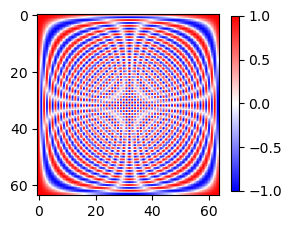

In [19]:
fig, ax = plt.subplots(1,1,figsize=(2.5,2.5))
C1=ax.imshow(W_rdft,vmin=-1,vmax=1,cmap=plt.get_cmap('bwr'))
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
cbar = fig.colorbar(C1, cax=cbar_ax)
plt.show()

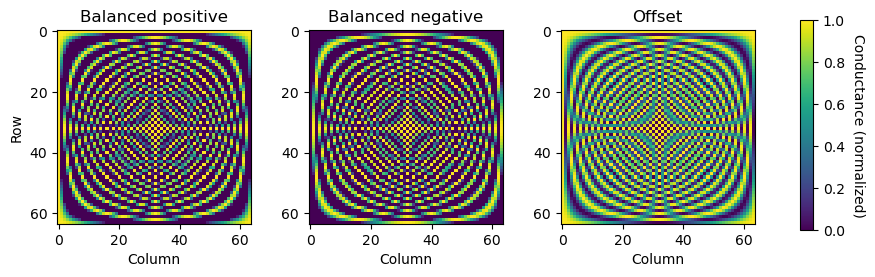

In [21]:
# Balanced core conductances
G_pos = xbar_balanced.cores[0][0].core_pos.matrix
G_neg = xbar_balanced.cores[0][0].core_neg.matrix

# Offset core conductances
G_offset = xbar_offset.cores[0][0].core.matrix

# Plot
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(9,3))
plt.subplots_adjust(wspace=0.3)
C1=ax1.imshow(G_pos, vmin=0, vmax=1)
ax2.imshow(G_neg, vmin=0, vmax=1)
ax3.imshow(G_offset, vmin=0, vmax=1)
ax1.set_title("Balanced positive")
ax2.set_title("Balanced negative")
ax3.set_title("Offset")
ax1.set_ylabel("Row")
for ax in (ax1,ax2,ax3):
    ax.set_xlabel("Column")
    ax.set_aspect("equal")
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.015, 0.7])
cbar = fig.colorbar(C1, cax=cbar_ax)
cbar.set_label("Conductance (normalized)",rotation=270,labelpad=15)

# Save the figure
fig.savefig('amp_conductance_visualization.png')

plt.show()

The Balanced model uses two separate conductance arrays to represent positive and negative weights, as indicated by the "Balanced positive" and "Balanced negative" titles. For the Balance model, the patterns show that the positive and negative parts of the signal are treated separately but in a complementary fashion, allowing for a potentially higher dynamic range and more linear behavior in the representation of the original matrix values.

The Offset model uses a single array to represent both positive and negative weights by introducing an offset. This means the zero point (no weight) is shifted from zero conductance to some intermediate conductance value, allowing both positive and negative weights to be represented on a single scale. This approach simplifies the hardware since only one conductance array is used, but it can lead to issues with symmetry and linearity, as the zero point is no longer at the natural zero of conductance.

# Device programming error

The concept of device programming error in Analog Matrix Processors (AMPs) is significant because it represents the imperfections inherent in programming the conductance values in the analog crossbar. The errors arise from variations in the fabrication process, material inconsistencies, and the fundamental limitations of the analog devices.

There are two types of programming errors presented in the simulator: State-Independent (SI) and State-Proportional (SP) errors.

## State-Independent (SI) Error
This error model assumes that the error in setting the conductance of a device is independent of the actual conductance value. It's constant across all states and typically represented by a fixed standard deviation in the distribution of conductance values. This error can be particularly impactful when dealing with low conductance values because it represents a larger proportion of the total conductance.

## State-Proportional (SP) Error
In contrast, the SP error model posits that the error is proportional to the conductance value itself. The higher the target conductance, the larger the absolute error. This model reflects physical scenarios where the precision of setting a state is related to the magnitude of that state, such as due to relative variations or non-linearities in the response of the conductive material.



In [23]:
# Create a DFT matrix
N_ft = 64
W_dft = scipy.linalg.dft(N_ft)

# Choose alpha to be 25%
alpha = 0.25

# Define a base set of params to use for all cores:
base_args = {'weight_bits' : 8, 'complex_matrix' : True, 'Rmin': 1e3, 'Rmax' : 1e6,
             'error_model' : 'generic', 'alpha_error' : alpha, 'proportional_error' : True}
params_balanced = set_params(wtmodel = "BALANCED", **base_args)
params_offset = set_params(wtmodel = "OFFSET", **base_args)

# Create cores and program matrix
xbar_balanced = AnalogCore(W_dft, params = params_balanced)
xbar_offset = AnalogCore(W_dft, params = params_offset)

Mean absolute error in weight value
Balanced: 0.21528
  Offset: 0.34334


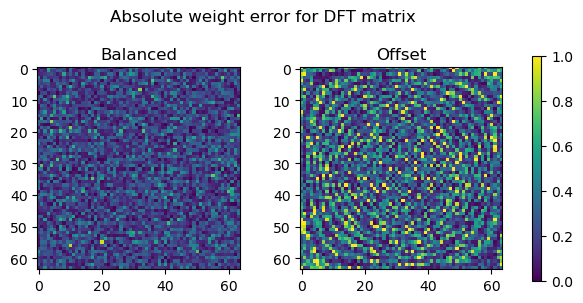

In [24]:
Werr_balanced = np.abs(W_dft - xbar_balanced.get_matrix())
Werr_offset = np.abs(W_dft - xbar_offset.get_matrix())

print("Mean absolute error in weight value")
print("===================================")
print("Balanced: {:.5f}".format(np.mean(Werr_balanced)))
print("  Offset: {:.5f}".format(np.mean(Werr_offset)))

# Visualize the distribution of errors across the matrix
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(6,3))
plt.subplots_adjust(wspace=0.3)
C1=ax1.imshow(Werr_balanced, vmin=0, vmax=1)
ax2.imshow(Werr_offset, vmin=0, vmax=1)
fig.suptitle("Absolute weight error for DFT matrix", fontsize=12, y=1.025)
ax1.set_title("Balanced", fontsize=12)
ax2.set_title("Offset", fontsize=12)
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.12, 0.015, 0.75])
cbar = fig.colorbar(C1, cax=cbar_ax)
plt.show()

The code effectively demonstrates how different AMP core configurations handle the programming of a DFT matrix and quantifies the impact of programming errors. By comparing the mean absolute errors and visualizing the error distribution, one can infer which model might be more robust to programming errors.

These results show that for applications requiring high precision, such as signal processing or deep learning, the Balanced model might be preferable due to its more uniform error distribution. In contrast, the Offset model may require more sophisticated error correction techniques to be viable in precision-critical applications.